In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [4]:
# -----------------------
# CONFIG
# -----------------------
pulse_samples = 1000     # n_feat_muon
n_feat_frec = 2500       # n_feat_frec
batch_size = 64
epochs = 80
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 9

# Paths a tus datasets
muon_dataset_path = "muon_dataset_segmented_v3.npz"
simulated_npz_path = "Espectros/spectrum_simulated.npz"
real_npz_path = "Espectros/spectrum_real.npz"

print("Device:", device)

# -----------------------
# CARGA DE DATASET DE MUONES
# -----------------------
data = np.load(muon_dataset_path)
X_muones = data['X']        # shape (num_pulsos, pulse_samples)
y_muones = data['y']        # shape (num_pulsos,)

# -----------------------
# Normalizar pulsos de muones al mismo rango
# -----------------------
# Tomar el máximo global de todos los pulsos
max_global = X_muones.max()

# Escalar todos los pulsos para que el pulso con mayor valor llegue a 1
X_muones = X_muones / (max_global + 1e-8)  # evitar división por cero


# Convertir a tensores PyTorch
X_muones = torch.tensor(X_muones, dtype=torch.float32).unsqueeze(1)  # (N,1,pulse_samples)
y_muones = torch.tensor(y_muones, dtype=torch.long).squeeze()         # (N,)

print(f"Señales de muones: {X_muones.shape}, targets: {y_muones.shape}")

# -----------------------
# CARGA DE ESPECTROS
# -----------------------
def load_npz(path):
    data = np.load(path)
    freq = data['freq']
    att = data['attenuation_db']
    return torch.tensor(freq, dtype=torch.float32), torch.tensor(att, dtype=torch.float32)

sim_freq, H_sim = load_npz(simulated_npz_path)
real_freq, H_real = load_npz(real_npz_path)

# -----------------------
# Normalizar espectros simulados H_sim de 0 a 1
# -----------------------
H_sim_min = H_sim.min()
H_sim_max = H_sim.max()
H_sim_norm = (H_sim - H_sim_min) / (H_sim_max - H_sim_min + 1e-8)  # evitar división por cero

# Repetir para cada ejemplo
H_sim_batch = H_sim_norm.repeat(X_muones.shape[0], 1)  # (N, n_feat_frec)

Device: cpu
Señales de muones: torch.Size([10000, 1, 1000]), targets: torch.Size([10000])


In [5]:
# -----------------------
# DEFINICIÓN DE LA RED
# -----------------------
class TwoBranchNet(nn.Module):
    def __init__(self, n_feat_muon=1000, n_feat_frec=2500, n_classes=21):
        super(TwoBranchNet, self).__init__()
        
        # --- Rama CNN Muones ---
        self.cnn_branch = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),         
            nn.MaxPool1d(2),
            

            nn.Conv1d(128, 256, kernel_size=5, padding='same'),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(1),  # (batch, 256, 1)
            nn.Flatten()
        )
        
        # Rama 2: Respuesta en frecuencia simulada (MLP)
        self.mlp_branch = nn.Sequential(
            nn.Linear(n_feat_frec, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )

        # --- Cabezal de fusión ---
        self.head = nn.Sequential(
            nn.Linear(256 + 32, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x_muon, x_freq):
        v1 = self.cnn_branch(x_muon)
        v1 = v1.view(v1.size(0), -1)
        v2 = self.mlp_branch(x_freq)
        merged = torch.cat([v1, v2], dim=1)
        out = self.head(merged)
        return out

# -----------------------
# Inicializar modelo
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=21).to(device)
summary(model, input_size=[(1,1,1000), (1,2500)])

Layer (type:depth-idx)                   Output Shape              Param #
TwoBranchNet                             [1, 21]                   --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Conv1d: 2-1                       [1, 64, 1000]             1,024
│    └─BatchNorm1d: 2-2                  [1, 64, 1000]             128
│    └─LeakyReLU: 2-3                    [1, 64, 1000]             --
│    └─MaxPool1d: 2-4                    [1, 64, 500]              --
│    └─Conv1d: 2-5                       [1, 128, 500]             57,472
│    └─BatchNorm1d: 2-6                  [1, 128, 500]             256
│    └─LeakyReLU: 2-7                    [1, 128, 500]             --
│    └─MaxPool1d: 2-8                    [1, 128, 250]             --
│    └─Conv1d: 2-9                       [1, 256, 250]             164,096
│    └─BatchNorm1d: 2-10                 [1, 256, 250]             512
│    └─LeakyReLU: 2-11                   [1, 256, 250]             --


Device: cpu
Train size: 5600, Val size: 2400, Test size: 2000
Epoch 1/30 | Train Loss: 1.5053, Acc: 0.3546 | Val Loss: 1.3677, Acc: 0.3967
Epoch 2/30 | Train Loss: 1.3627, Acc: 0.3762 | Val Loss: 1.3470, Acc: 0.3967
Epoch 3/30 | Train Loss: 1.3534, Acc: 0.3832 | Val Loss: 1.3440, Acc: 0.3967
Epoch 4/30 | Train Loss: 1.3510, Acc: 0.3709 | Val Loss: 1.3496, Acc: 0.3967
Epoch 5/30 | Train Loss: 1.3508, Acc: 0.3748 | Val Loss: 1.3406, Acc: 0.3967
Epoch 6/30 | Train Loss: 1.3480, Acc: 0.3695 | Val Loss: 1.3420, Acc: 0.3967
Epoch 7/30 | Train Loss: 1.3429, Acc: 0.3750 | Val Loss: 1.3529, Acc: 0.3542
Epoch 8/30 | Train Loss: 1.3280, Acc: 0.4002 | Val Loss: 1.2637, Acc: 0.3967
Epoch 9/30 | Train Loss: 0.9727, Acc: 0.6332 | Val Loss: 0.7605, Acc: 0.7417
Epoch 10/30 | Train Loss: 0.8168, Acc: 0.6861 | Val Loss: 0.7349, Acc: 0.7258
Epoch 11/30 | Train Loss: 0.7805, Acc: 0.6964 | Val Loss: 0.7954, Acc: 0.6975
Epoch 12/30 | Train Loss: 0.7868, Acc: 0.6950 | Val Loss: 0.7350, Acc: 0.7300
Epoch 13/30

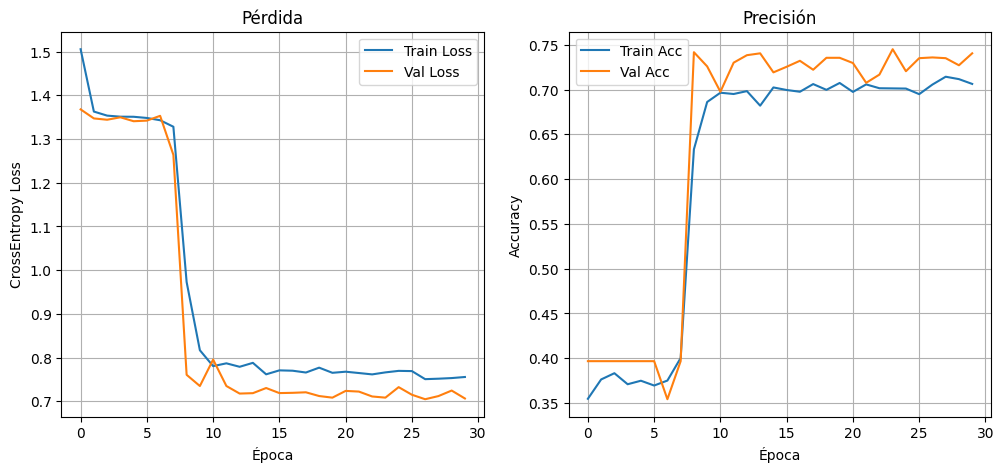

In [33]:
# -----------------------
# Datasets y DataLoaders
# -----------------------
dataset = TensorDataset(X_muones, H_sim_batch, y_muones)

# Primer split: Train+Val vs Test (80/20)
n_total = len(dataset)
n_trainval = int(0.8 * n_total)
n_test = n_total - n_trainval
trainval_dataset, test_dataset = random_split(dataset, [n_trainval, n_test])

# Segundo split: Train vs Val (70/30 del 80%)
n_train = int(0.7 * n_trainval)
n_val   = n_trainval - n_train
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# -----------------------
# Inicialización de modelo, optimizer y scheduler
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# -----------------------
# Custom Loss: CrossEntropy + Penalización de cero
# -----------------------
def custom_loss_distance(outputs, targets, min_prob=0.05, alpha=100.0):
    """
    CrossEntropy + penalización más fuerte para clases presentes con baja fracción de predicción.
    Penalización decrece suavemente si la fracción aumenta.
    
    min_prob: fracción mínima esperada de predicciones por clase presente
    alpha: escala de penalización
    """
    ce = nn.CrossEntropyLoss()(outputs, targets)
    
    probs = torch.softmax(outputs, dim=1)
    present_classes = torch.unique(targets)

    penalty = 0.0
    for c in present_classes:
        pred_fraction = (probs.argmax(dim=1) == c).float().mean()

        # Diferencia respecto al mínimo
        diff = torch.relu(min_prob - pred_fraction)

        # Penalización cuadrática -> más fuerte si está muy cerca de 0
        penalty += diff ** 2  
    
    penalty = penalty / len(present_classes)
    return ce + alpha * penalty


# -----------------------
# Entrenamiento
# -----------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for x_muon_batch, x_freq_batch, y_batch in train_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_muon_batch, x_freq_batch)
        loss = custom_loss_distance(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_muon_batch.size(0)
        preds = output.argmax(dim=1)
        running_corrects += (preds == y_batch).sum().item()

    epoch_loss = running_loss / n_train
    epoch_acc  = running_corrects / n_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ---- Validation ----
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for x_muon_batch, x_freq_batch, y_batch in val_loader:
            x_muon_batch = x_muon_batch.to(device)
            x_freq_batch = x_freq_batch.to(device)
            y_batch = y_batch.to(device)

            val_output = model(x_muon_batch, x_freq_batch)
            val_loss = custom_loss_distance(val_output, y_batch)

            val_running_loss += val_loss.item() * x_muon_batch.size(0)
            preds = val_output.argmax(dim=1)
            val_running_corrects += (preds == y_batch).sum().item()

    val_epoch_loss = val_running_loss / n_val
    val_epoch_acc  = val_running_corrects / n_val
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    scheduler.step(val_epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

# -----------------------
# Guardar pesos
# -----------------------
os.makedirs("model_weights", exist_ok=True)
torch.save(model.state_dict(), "model_weights/two_branch_net.pth")
print("Pesos guardados en 'model_weights/two_branch_net.pth'")

# -----------------------
# Evaluación y métricas
# -----------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_muon_batch, x_freq_batch, y_batch in test_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_muon_batch, x_freq_batch)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds, labels=list(range(n_classes)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(all_labels, all_preds, digits=4))

# -----------------------
# Plot de pérdida y accuracy
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("CrossEntropy Loss")
plt.title("Pérdida")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Evaluación sobre set de validación
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_muon_batch, x_freq_batch, y_batch in val_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)
        
        preds = model(x_muon_batch, x_freq_batch)
        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

all_preds = torch.cat(all_preds).numpy().flatten()
all_targets = torch.cat(all_targets).numpy().flatten()

# Plot distribución
plt.figure(figsize=(10,4))
plt.hist(all_targets, bins=21, alpha=0.5, label='Targets (0-20)')
plt.hist(all_preds, bins=21, alpha=0.5, label='Predicciones')
plt.xlabel('Número de unos')
plt.ylabel('Cantidad de ejemplos')
plt.title('Distribución de predicciones vs targets en validación')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# -----------------------
# Datos de testeo
# -----------------------
# Asumimos que ya hiciste el split train/val/test
# Por ejemplo:
# train_dataset, val_dataset, test_dataset = ...
# Aquí extraemos los tensores:
X_test = X_muones[val_dataset.indices]  # o tu test_dataset
y_test = y_muones[val_dataset.indices]

# Repetir H_sim para cada ejemplo
H_sim_test = H_sim.repeat(X_test.shape[0], 1)

# Mover a device
X_test = X_test.to(device)
H_sim_test = H_sim_test.to(device)
y_test = y_test.to(device)

# -----------------------
# Predicción
# -----------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test, H_sim_test)

# Convertir a numpy
y_pred_np = y_pred.cpu().numpy().flatten()
y_test_np = y_test.cpu().numpy().flatten()

# -----------------------
# Histograma
# -----------------------
plt.figure(figsize=(10,5))
plt.hist(y_test_np, bins=50, alpha=0.5, label="Real (#unos)")
plt.hist(y_pred_np, bins=50, alpha=0.5, label="Predicho (#unos)")
plt.xlabel("Número de unos consecutivos")
plt.ylabel("Cantidad de pulsos")
plt.title("Distribución de unos: real vs predicho")
plt.legend()
plt.grid(True)
plt.show()
